# Cell cycle visualization for single-cell RNAseq data

In this jupyter notebook we propose a short example for the use of the **sica.singlecell.ica** function. This function mimics [scanpy.pp.pca](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.pca.html) and allows the user to apply our stabilized ICA approach on annotated data (i.e [anndata](https://anndata.readthedocs.io/en/latest/)). In this notebook we study the extraction of the cell cyle from single-cell RNA-seq data.

**Note :** here we simply carry out a very basic analysis of cell cyle to illustrate the **sica.singlecell.ica** function. Many more complex and relevant analyses could be perform and we advise interested readers to refer to the package [scycle](https://github.com/csgroen/scycle) or the notebook of Andrei Zinovyev [Cell_Cycle_gene_dynamics_visualization](https://www.kaggle.com/andreizinovyev/cell-cycle-gene-dynamics-visualization).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scanpy as sc
import seaborn as sns
import time

## 0. Load the data set

You can download the data from [this link](https://www.kaggle.com/alexandervc/rna-seq-data?select=CHLA9.h5ad) (in .h5ad format). This data set comes from an Ewing-sarcoma cell line named CHLA9 and purchased from the Children Oncology's Group (COG) for a study led by Millet *et al.* [1].

In [2]:
adata = sc.read_h5ad('data/CHLA9.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 5061 × 60662
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

## 1. Basic pre-processing for single-cell data

Here we apply basic pre-processing operations. We follow a tutorial of scanpy that can be found [here](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) (this tutorial itself is based on another tutorial [Analyzing single-cell RNA-seq data containing read counts - Lun *et al* 2018](https://bioc.ism.ac.jp/packages/3.7/workflows/vignettes/simpleSingleCell/inst/doc/work-1-reads.html)).

**Note:** The following pre-processing is one of the simplest for single-cell data. Many more complex methods have been proposed and the choice of an efficient pre-processing protocol for removing technical biases has not reached any consensus yet. Here we just want to keep things simple.

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

We want to remove low quality cells in order to limit the influence of technical effects. To do so, we use several basic metrics: 
- **total number of counts across all genes** - a too low total counts may indicate that RNA has not been efficiently captured.
- **number of genes expressed in the counts matrix** - a too low number of expressed genes may indicate that the diverse transcript population has not been successfully captured.
- **percentage of counts in mitochondrial genes** - a high percentage may be indicative of poor-quality cells, possibly because of loss of cytoplasmic RNA from perforated cells.

In the following, we first plot the distribution of each metric with violin plots and then visually select relevant thresholds to filter out low quality cells.

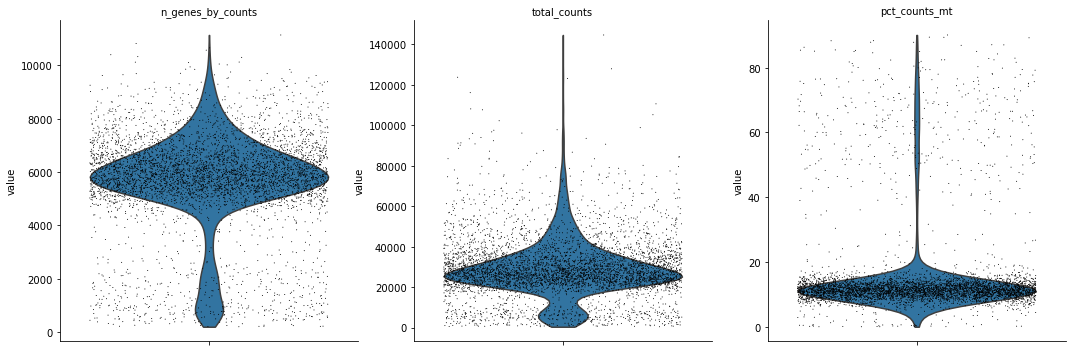

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  #annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [6]:
adata = adata[adata.obs.n_genes_by_counts > 5000, :]
adata = adata[adata.obs.n_genes_by_counts  < 9000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

We then apply two different transformations :
- **Normalization of every cell by the total counts over all genes** - it aims to eliminate the cell-specific biases that may come with differences in capture, reverse transcription and sequencing efficiency of mRNA between cells. 
- **Log2(1 + x) transformation** - in particular, it ensures that high-abundance genes with large variances do not dominate downstream analyses.

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

C:\Users\ncaptier\anaconda3\envs\sica_env\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Finally we want to reduce the dimension by keeping only the most variable genes. This assumes that genuine biological differences will manifest as increased variation in the affected genes, compared to other genes that are only affected by technical noise or a baseline level of “uninteresting” biological variation.

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes = 10000)
adata = adata[:, adata.var.highly_variable]

In [9]:
# Conversion from sparse adata.X to dense adata.X using only 10 000 top highly variable genes
XX2 = adata.X.toarray()
adata = anndata.AnnData(XX2,  obs=adata.obs.copy(), var=adata.var.copy() )

## 2. Apply stabilized ICA

In [10]:
from sica.singlecell import ica

In the following step, we center the expression of each gene to avoid extracting an ICA component that would be entirely driven by the differences between the mean expression of each gene.

In [11]:
adata.X -= adata.X.mean(axis =0)

FastICA from sklearn did not converge due to numerical instabilities - Retrying...
running time (min): 01:14.82


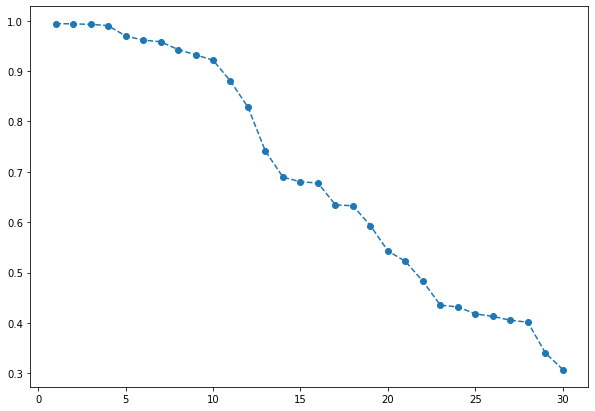

In [12]:
start = time.time()
ica(adata , observations = 'genes' , n_components = 30 , n_runs = 100)
minutes, seconds = divmod(time.time() - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

plt.figure(figsize = (10 , 7))
plt.plot(range(1 , 31) , adata.uns['sica']['stability_indexes'] , linestyle='--', marker='o')

**Note:** here the choice of the number of ICA components to extract (`n_components = 30`) is quite arbitrary. We chose 30 because in several experiments we ran with single-cell data it roughly offered a satisfying compromise between a high overall stability and a sufficiently large number of components.

In [13]:
Metagenes = pd.DataFrame(adata.varm['sica_metagenes'].T , columns = adata.var['Accession'].values , index = ['metagene ' + str(i) for i in range(adata.varm['sica_metagenes'].shape[1])])

Metasamples = pd.DataFrame(adata.obsm['sica_metasamples'] , index = adata.obs.index , columns = ['metagene ' + str(i) for i in range(adata.varm['sica_metagenes'].shape[1])])

## 3. Toppfun enrichment analysis for detecting cell cycle metagenes

In this section, we perform an exploratory analysis among the 30 extracted stabilized ICA components, looking for those which relate to cell cycle. This requires repeating the following operations for each metagene (or, at least, the most stable ones) : 
- Use the **sica.annotate.toppfun** tool to biologically annotate the metagene. This tool first retrieves the most expressed genes associated to the component and then performs enrichment analysis for this small subset of genes with [Toppfun](https://toppgene.cchmc.org/enrichment.jsp).
- If the Toppfun enrichment analysis highlights processes associated to cell cyle, save the index (ex : metagene 2 is associated with the index 2) in the potential_ccycle_genes list.

**Warning :** this process is not completely reproducible as ICA metagenes will not be ranked exactly the same way from one run to another. When running this notebook one may find different indexes for the cell cycle metagenes and should update the potential_ccycle_genes list accordingly.

In [14]:
from sica.annotate import toppfun

In [15]:
Tannot = toppfun.ToppFunAnalysis(data = Metagenes , threshold = 3 , method = 'std', tail = 'heaviest')

You just need to repeat the following cell and change, each time, the name of the metagene in the first line (i.e `metagene = 'metagene 0'` , `metagene = 'metagene 1'` , `metagene = 'metagene 2'` ...)

In [30]:
df_annot = Tannot.get_analysis(metagene = 'metagene 14')

#We only display GO biological processes, pathways and pubmed articles

GO_processes = df_annot['Category']== 'GeneOntologyBiologicalProcess'
pathways = df_annot['Category']== 'Pathway'
pubmed = df_annot['Category']== 'Pubmed'

df_annot[GO_processes | pathways | pubmed].head(5)

Enrichment analysis success!


Category          ID                        Name  \
10  GeneOntologyBiologicalProcess  GO:0035148              tube formation   
11  GeneOntologyBiologicalProcess  GO:0060485      mesenchyme development   
12  GeneOntologyBiologicalProcess  GO:0007411               axon guidance   
13  GeneOntologyBiologicalProcess  GO:0097485  neuron projection guidance   
14  GeneOntologyBiologicalProcess  GO:0021915     neural tube development   

          PValue   QValueFDRBH   QValueFDRBY  QValueBonferroni  TotalGenes  \
10  2.703017e-11  5.092154e-08  4.334759e-07      7.552230e-08       20669   
11  3.645064e-11  5.092154e-08  4.334759e-07      1.018431e-07       20669   
12  1.102263e-10  7.983229e-08  6.795823e-07      3.079723e-07       20669   
13  1.142910e-10  7.983229e-08  6.795823e-07      3.193292e-07       20669   
14  1.806813e-10  1.009647e-07  8.594749e-07      5.048237e-07       20669   

    GenesInTerm  GenesInQuery  GenesInTermInQuery Source URL  \
10          234           110                  14              
11          458           110                  18              
12          427           110                  17              
13          428           110                  17              
14          270           110                  14              

                                          Gene_Symbol  
10  SOX4,SOX11,LMO4,MDK,ZEB2,CLDN1,ZIC2,TWIST1,CIT...  
11  MYC,SOX11,ZNF703,SEMA3C,MDK,ZEB2,ZIC2,TWIST1,C...  
12  SEMA3C,GAS1,ARTN,ZSWIM6,RUNX3,PCDH17,ZIC2,RHOH...  
13  SEMA3C,GAS1,ARTN,ZSWIM6,RUNX3,PCDH17,ZIC2,RHOH...  
14  SOX4,SOX11,SEMA3C,GAS1,LMO4,MDK,ZEB2,ZIC2,TWIS...

In [31]:
potential_ccycle_genes = [0 , 2 , 3 , 5, 9 , 10]

## 4. Cell cycle visualization in 2D

We can now display the pairwise scatter plots of the cell cycle ICA components selected above. For each of these plots we can highlight the total number of counts for each cell (which was saved before the normalization step) with a color scale blue-green-yellow. The total number of counts should grow along the cell cyle until the mitosis and experience a significant drop just after it.

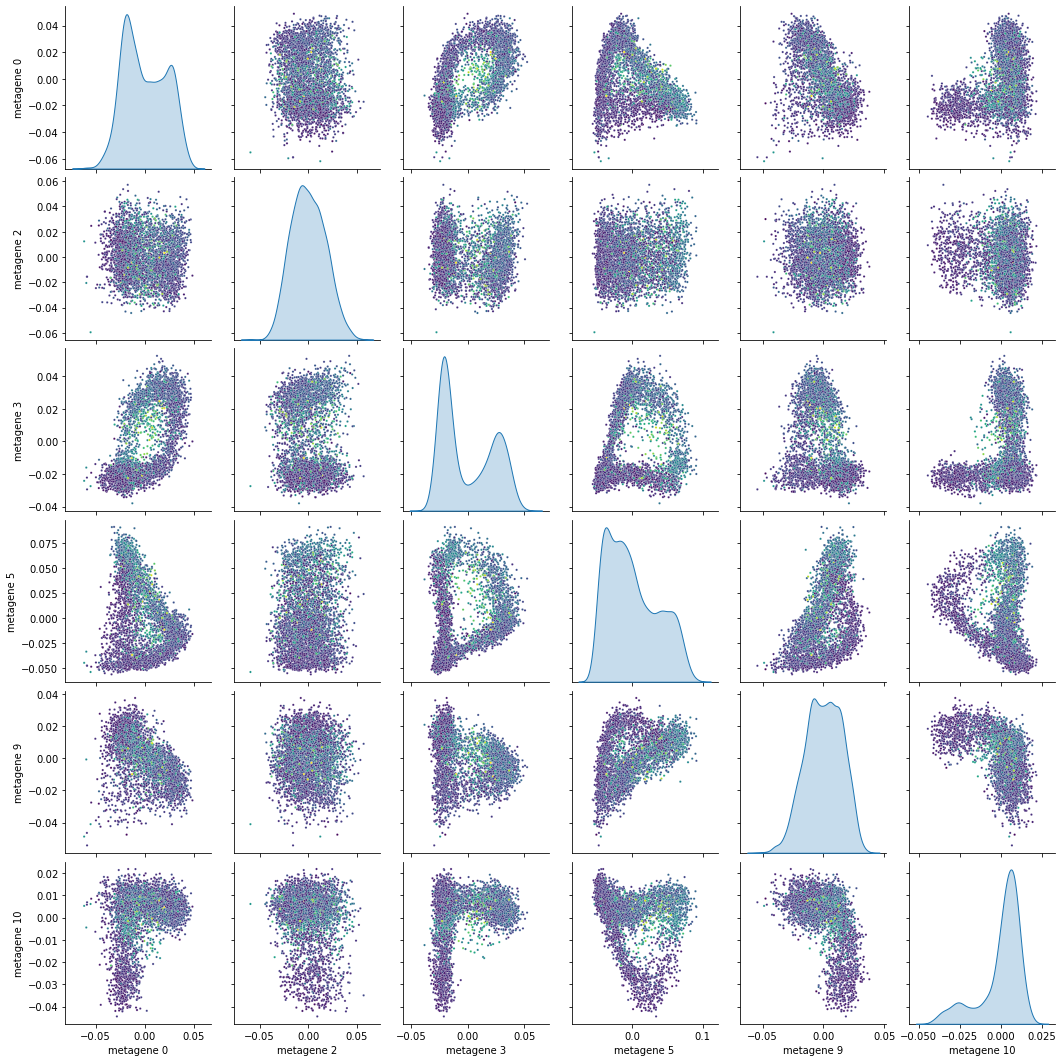

In [32]:
sns.pairplot(Metasamples.iloc[: , potential_ccycle_genes] , diag_kind="kde" , plot_kws={"s": 5 , "c" : adata.obs['total_counts'].values , "cmap" : 'viridis'})

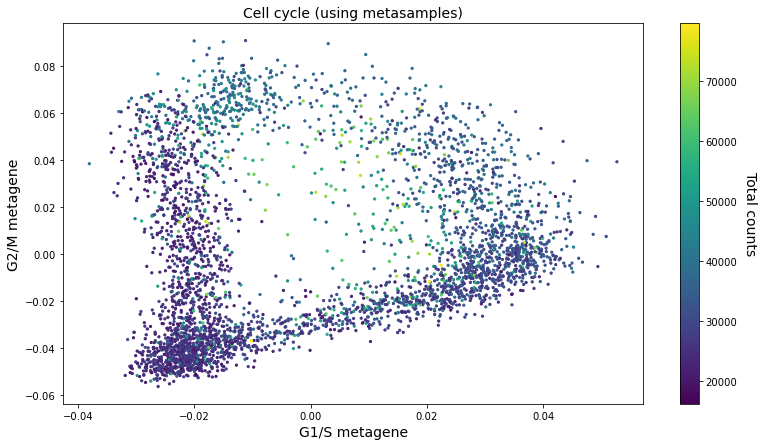

In [33]:
fig, ax = plt.subplots(figsize = (13 , 7))
im = ax.scatter(adata.obsm['sica_metasamples'][: , 3] , adata.obsm['sica_metasamples'][: , 5] , s=5 , c = adata.obs['total_counts'].values , cmap = 'viridis')
ax.set_title("Cell cycle (using metasamples)" , fontsize = 14)
ax.set_xlabel("G1/S metagene" , fontsize = 14)
ax.set_ylabel("G2/M metagene" , fontsize = 14)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Total counts" , fontsize = 14 , rotation=270 , labelpad=20)

Instead of using the raw results of ICA (i.e metasamples) for plotting the cell cyle we can simply retrieve the top expressed genes of the ICA components of interest and plot their average expression. This may be considered as a more simple and interpretable process. We simply display gene expressions rather than metasamples which are obtained from more complex computations.

Text(0, 0.5, 'G2/M metagene')

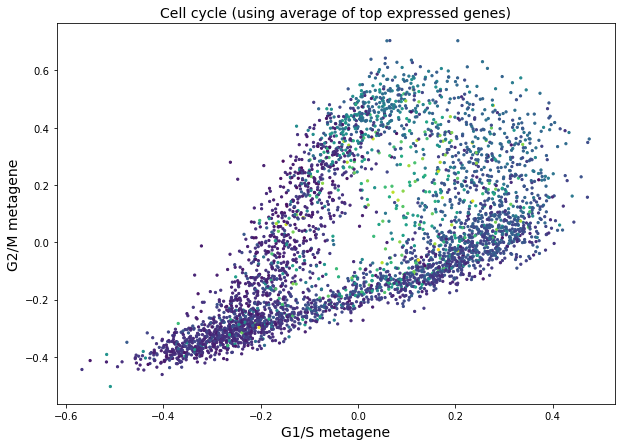

In [34]:
def fun(row , metagene):
    return (row in Tannot.top_genes_.loc[metagene]['inputs'])

var_x = adata.var[adata.var['Accession'].apply(fun , metagene = 'metagene 3')].index
var_y = adata.var[adata.var['Accession'].apply(fun , metagene = 'metagene 5')].index

plt.figure(figsize = (10 , 7))
plt.scatter(np.mean(adata[:,var_x].X , axis = 1) , np.mean(adata[:,var_y].X , axis = 1) , s=5 , c = adata.obs['total_counts'].values , cmap = 'viridis' )
plt.title("Cell cycle (using average of top expressed genes)" , fontsize = 14)
plt.xlabel("G1/S metagene" , fontsize = 14)
plt.ylabel("G2/M metagene" , fontsize = 14)

## 4. Cell cycle visualization in 3D (optional)

In [37]:
import plotly.graph_objects as go

In [38]:
fig = go.Figure(data=[go.Scatter3d(x=adata.obsm['sica_metasamples'][: , 3] , 
                                   y=adata.obsm['sica_metasamples'][: , 5]  , 
                                   z=adata.obsm['sica_metasamples'][: , 2], 
                                   marker=dict(size=3,
                                               line=dict(width=0.5, color='DarkSlateGrey'),
                                               color=adata.obsm['sica_metasamples'][: , 10],
                                               colorbar = dict(title = 'Other cell cyle component' , x = -0.1),
                                               colorscale="piyg"
                                                ),
                                   mode = 'markers',
                                   name = 'chla9')])

fig.update_layout(autosize=False,
                  width=1200,
                  height=600,
                  title="CHLA9 (3D cell cycle)",
                  legend_title="Data set" ,
                  scene = dict(yaxis_title='G1/S metagene', xaxis_title='G2-M metagene',
                               zaxis_title='cc metagene'  , xaxis_autorange="reversed")
                 )
    

fig.show()

#fig.write_html("cc_CHLA9_ICA.html")

## 5. A brief comparison with PCA

In this section we show that, actually, a simple PCA is also able to retrieve a cycling pattern. Indeed, the signal associated to cell cycle is particularly strong in the CHLA9 cell line. We can still argue that PCA components are more difficult to interpret than ICA components. ICA gives you a chance to easily identify the genes that may drive the cell cycle (i.e the four steps G1, S, G2 and mitosis).

In [35]:
sc.pp.pca(adata , n_comps = 30)

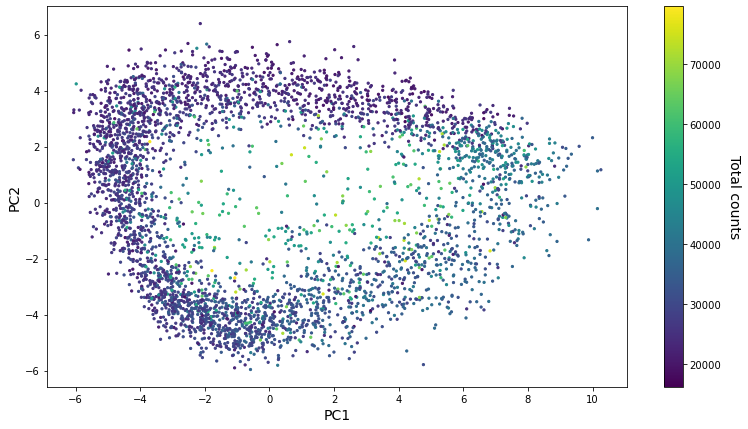

In [36]:
fig, ax = plt.subplots(figsize = (13 , 7))
im = plt.scatter(adata.obsm['X_pca'][: , 0] , adata.obsm['X_pca'][: , 1] , s=5 , c = adata.obs['total_counts'].values , cmap = 'viridis' )
ax.set_xlabel("PC1" , fontsize = 14)
ax.set_ylabel("PC2" , fontsize = 14)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Total counts" , fontsize = 14 , rotation=270 , labelpad=20)

## References

**[1]** : Miller, H.E.; Gorthi, A.; Bassani, N.; Lawrence, L.A.; Iskra, B.S.; Bishop, A.J.R. Reconstruction of Ewing Sarcoma Developmental Context from Mass-Scale Transcriptomics Reveals Characteristics of EWSR1-FLI1 Permissibility. Cancers 2020, 12, 948. https://doi.org/10.3390/cancers12040948   